In [1]:
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For visualizations
import seaborn as sns  # For advanced visualizations
from textblob import TextBlob  # For sentiment analysis
from sklearn.model_selection import train_test_split  # For splitting data
from sklearn.linear_model import LogisticRegression  # ML model
from sklearn.ensemble import RandomForestClassifier  # Ensemble model
from sklearn.svm import SVC  # Support Vector Machine model
import os

In [2]:
# Load the dataset
# This is the step where external data is brought into the project.
data = pd.read_csv("OnlineNewsPopularity.csv", encoding="ISO-8859-1")

# Shuffle and split
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
half = len(data) // 2
part1 = data.iloc[:half]
part2 = data.iloc[half:]

# Save the two parts
part1.to_csv("dataset_part1.csv", index=False)
part2.to_csv("dataset_part2.csv", index=False)

# Print number of rows in original and each part
print("Original dataset size:", len(data))
print("Part 1 size:", len(part1))
print("Part 2 size:", len(part2))

# Optional: Check if all rows are accounted for
print("Total after split:", len(part1) + len(part2))

Original dataset size: 39644
Part 1 size: 19822
Part 2 size: 19822
Total after split: 39644


In [3]:
!pip install ydata-profiling

In [4]:
# Clean the dataset to prepare it for analysis and modeling.
# Includes handling missing values and formatting the 'Date' column if it exists.
if 'Date' in data.columns:
	data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Simple checks 
print("shape of the dataset:", data.shape)  # How many rows and columns do you have?
print("How many articles?", len(data))  # How big is your dataset?
print("What columns do I have?", data.columns.tolist())
print("Any missing data?", data.isnull().sum())  # Are there any gaps in your data?

print(data.head())
print(data.info())

shape of the dataset: (39644, 61)
How many articles? 39644
What columns do I have? ['url', ' timedelta', ' n_tokens_title', ' n_tokens_content', ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos', ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle', ' data_channel_is_entertainment', ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech', ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min', ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares', ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity', ' global_sentiment_polarity', ' gl

Top News Channels (lifestyle):
data_channel_is_lifestyle
0.0    37545
1.0     2099
Name: count, dtype: int64


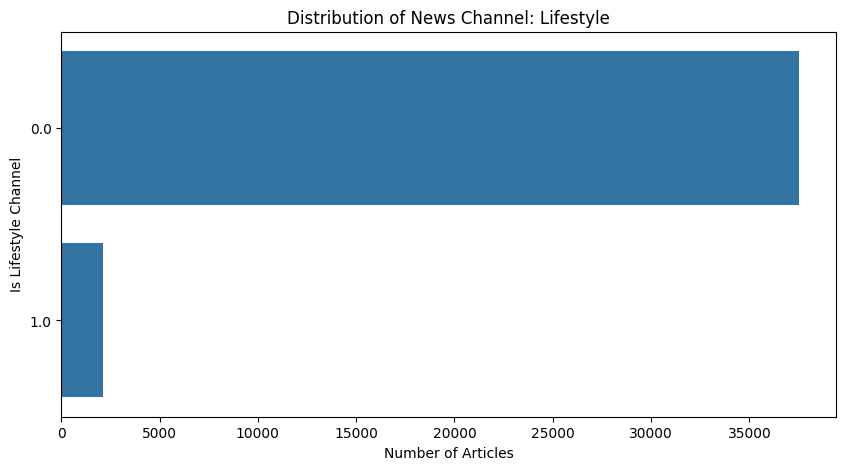

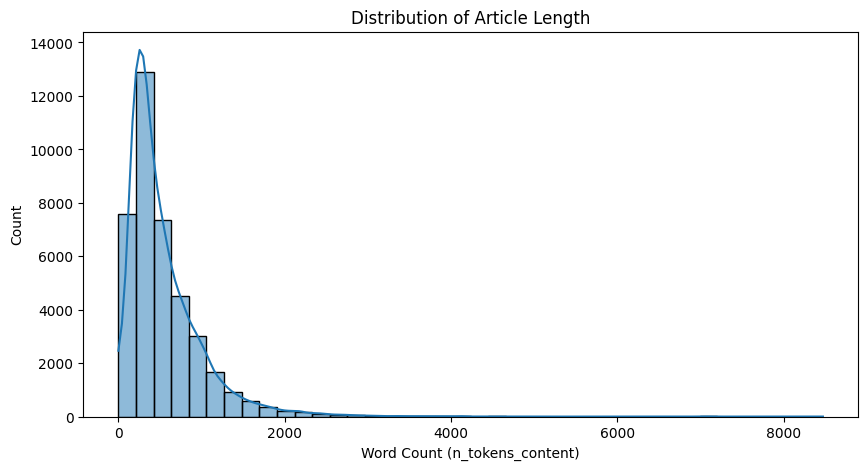

Column 'Date' not found in data. Skipping monthly trend plot.


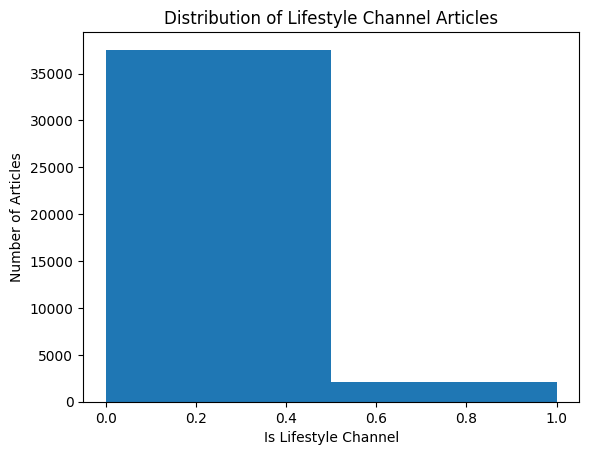

Column 'Date' not found in data. Skipping hourly trend plot.


In [5]:
# --- Univariate Analysis ---

# Remove leading/trailing spaces from column names (do this once at the top of your analysis)
data.columns = data.columns.str.strip()

# Print the most common types of news articles using a valid column
print("Top News Channels (lifestyle):")
print(data['data_channel_is_lifestyle'].value_counts())

# Plot News Channel distribution (using 'data_channel_is_lifestyle' as an example)
plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='data_channel_is_lifestyle', order=data['data_channel_is_lifestyle'].value_counts().index)
plt.title("Distribution of News Channel: Lifestyle")
plt.xlabel("Number of Articles")
plt.ylabel("Is Lifestyle Channel")
plt.show()

# Article length analysis
# Use the 'n_tokens_content' column as a proxy for article length (number of words/tokens)
plt.figure(figsize=(10, 5))
sns.histplot(data['n_tokens_content'], bins=40, kde=True)
plt.title("Distribution of Article Length")
plt.xlabel("Word Count (n_tokens_content)")
plt.show()

# Time trend (articles per month)
# Only run if 'Date' column exists
if 'Date' in data.columns:
	data['Month'] = data['Date'].dt.to_period('M')
	monthly_counts = data['Month'].value_counts().sort_index()
	monthly_counts.plot(kind='bar', figsize=(12, 5), title="Articles Published per Month")
	plt.ylabel("Article Count")
	plt.show()
else:
	print("Column 'Date' not found in data. Skipping monthly trend plot.")

# Plot the distribution of a valid column (e.g., 'data_channel_is_lifestyle') using histogram (alternative view)
plt.hist(data['data_channel_is_lifestyle'], bins=len(data['data_channel_is_lifestyle'].unique()))
plt.title('Distribution of Lifestyle Channel Articles')
plt.xlabel('Is Lifestyle Channel')
plt.ylabel('Number of Articles')
plt.show()

# When are articles most frequently published?
# Extract hour of the day from timestamp
# Shows the frequency of article publications by hour (0-23)
if 'Date' in data.columns:
	data['hour'] = data['Date'].dt.hour
	hourly_counts = data['hour'].value_counts().sort_index()

	plt.plot(hourly_counts.index, hourly_counts.values, marker='o')
	plt.title('Number of Articles Published by Hour')
	plt.xlabel('Hour of Day (0-23)')
	plt.ylabel('Number of Articles')
	plt.show()
else:
	print("Column 'Date' not found in data. Skipping hourly trend plot.")

In [6]:
from imblearn.over_sampling import RandomOverSampler

# Address class imbalance using RandomOverSampler from imblearn

# Define features and target
X = data.drop(['url', 'shares'], axis=1)
y = data['shares'] > data['shares'].median()  # Binary target: 1 if above median, else 0

# Apply oversampling
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

print("Original class distribution:", y.value_counts())
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())

Original class distribution: shares
False    20082
True     19562
Name: count, dtype: int64
Resampled class distribution: shares
True     20082
False    20082
Name: count, dtype: int64


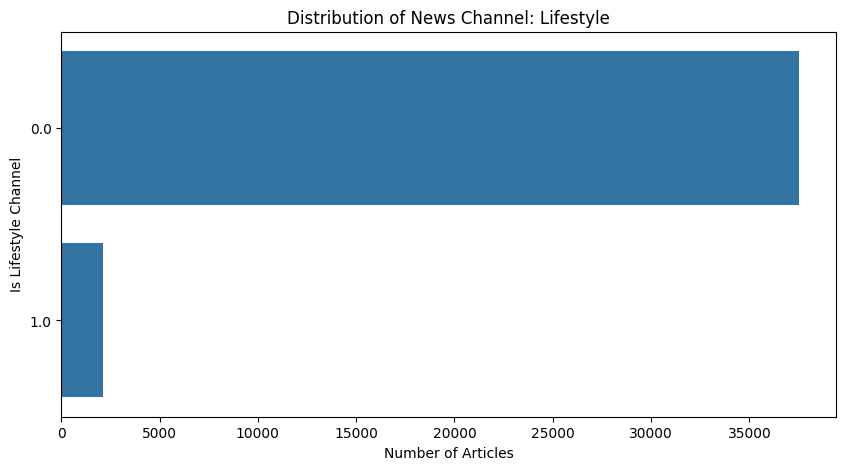

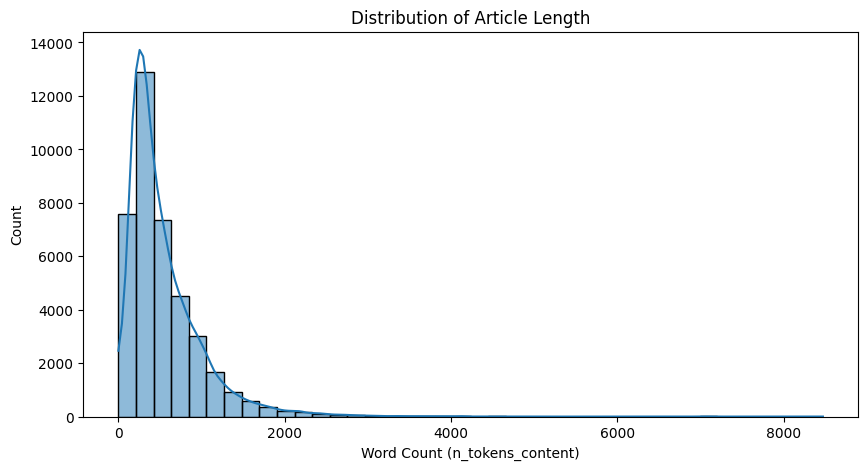

In [7]:
# Plot News Channel distribution (using 'data_channel_is_lifestyle' as an example)
plt.figure(figsize=(10, 5))
sns.countplot(data=data, y='data_channel_is_lifestyle', order=data['data_channel_is_lifestyle'].value_counts().index)
plt.title("Distribution of News Channel: Lifestyle")
plt.xlabel("Number of Articles")
plt.ylabel("Is Lifestyle Channel")
plt.show()

# Article length analysis
plt.figure(figsize=(10, 5))
sns.histplot(data['n_tokens_content'], bins=40, kde=True)
plt.title("Distribution of Article Length")
plt.xlabel("Word Count (n_tokens_content)")
plt.show()

In [8]:
# Bin the 'shares' column into 'Low', 'Medium', and 'High' popularity based on quantiles

# Compute quantile thresholds
low_thresh = data['shares'].quantile(1/3)
high_thresh = data['shares'].quantile(2/3)

def grade_popularity(shares):
    if shares <= low_thresh:
        return 'Low'
    elif shares <= high_thresh:
        return 'Medium'
    else:
        return 'High'

data['popularity_grade'] = data['shares'].apply(grade_popularity)

# Show the distribution
print(data['popularity_grade'].value_counts())

popularity_grade
Low       14732
High      12955
Medium    11957
Name: count, dtype: int64


In [9]:
# Use available columns for feature engineering

# Feature: Title Length (number of tokens in title)
data['TitleLength'] = data['n_tokens_title']

# Feature: Article Length (number of tokens in content)
data['ArticleLength'] = data['n_tokens_content']

# Feature: Sentiment Polarity (already present as 'global_sentiment_polarity')
data['Sentiment'] = data['global_sentiment_polarity']

# Feature: Is Weekend (already present as 'is_weekend')
data['IsWeekend'] = data['is_weekend']

# Preview newly created features
print(data[['TitleLength', 'ArticleLength', 'Sentiment', 'IsWeekend']].head())

# Dataset overview
print(data.shape)  # Number of rows and columns
print(data.columns)  # List all columns

# Create a combined text length feature (sum of title and content tokens)
data['text_length'] = data['n_tokens_title'] + data['n_tokens_content']
print(data['text_length'].describe())  # Summary stats for text length

def label_virality(row):
    if abs(row['Sentiment']) > 0.3 and row['TitleLength'] < 12:
        return 'High'
    elif row['text_length'] < 1000 or row['TitleLength'] > 20:
        return 'Low'
    else:
        return 'Medium'

data['ViralityLevel'] = data.apply(label_virality, axis=1)
print(data['ViralityLevel'].value_counts())



   TitleLength  ArticleLength  Sentiment  IsWeekend
0         12.0         1015.0   0.159889        0.0
1          9.0          503.0   0.123520        0.0
2          9.0          232.0  -0.163235        0.0
3         12.0          171.0  -0.006410        0.0
4         11.0          286.0   0.060089        0.0
(39644, 66)
Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_i

In [ ]:
from pycaret.classification import *

# Ensure column names have no leading/trailing spaces
data.columns = data.columns.str.strip()

# Create 'popularity_grade' if not present
if 'popularity_grade' not in data.columns:
    low_thresh = data['shares'].quantile(1/3)
    high_thresh = data['shares'].quantile(2/3)
    def grade_popularity(shares):
        if shares <= low_thresh:
            return 'Low'
        elif shares <= high_thresh:
            return 'Medium'
        else:
            return 'High'
    data['popularity_grade'] = data['shares'].apply(grade_popularity)

# Combine available features to create a text column (using title/content token counts as proxy)
data['text'] = data['n_tokens_title'].astype(str) + ". " + data['n_tokens_content'].astype(str)

# Set up PyCaret for classification task
clf_setup = setup(
    data=data,
    target='popularity_grade',  # Use the categorical target
    session_id=42,  # For reproducibility
    text_features=['text'],   # Treat combined text column as NLP feature
    ignore_features=['url', 'shares'],  # Drop unused columns if needed
)

# Automatically compare and select the best-performing model
best_model = compare_models(exclude=['lda'])

# Predict using the best model on the same dataset (or new unseen data)
preds = predict_model(best_model)

# Save model to disk for future use
save_model(best_model, 'best_news_classifier')

,Description,Value
0,Session id,42
1,Target,popularity_grade
2,Target type,Multiclass
3,Target mapping,"High: 0, Low: 1, Medium: 2"
4,Original data shape,"(39644, 69)"
5,Transformed data shape,"(39644, 2293)"
6,Transformed train set shape,"(27750, 2293)"
7,Transformed test set shape,"(11894, 2293)"
8,Ignore features,2
9,Numeric features,64


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,12:46:28
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)


Processing:   0%|          | 0/57 [00:00<?, ?it/s]